In [41]:
import re
import string
import warnings
from pathlib import Path
from time import time

import common_data_processing as dphelp
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotnine as gg
import seaborn as sns
from plotnine import aes, ggplot

notebook_tic = time()

warnings.simplefilter(action="ignore", category=UserWarning)

_ = gg.theme_set(gg.theme_classic() + gg.theme(strip_background=gg.element_blank()))
%config InlineBackend.figure_format = "retina"

RANDOM_SEED = 847
np.random.seed(RANDOM_SEED)

muted_red, muted_blue = "#e41a1c", "#377eb8"

## Data

In [2]:
data_path = Path("..", "modeling_data", "depmap_CRC_data.csv")
data = (
    pd.read_csv(data_path, low_memory=False)
    .sort_values(["lineage", "depmap_id", "hugo_symbol", "sgrna"])
    .reset_index(drop=True)
)


cat_columns = ["lineage", "depmap_id", "hugo_symbol"]
for col in cat_columns:
    data = dphelp.make_cat(data, col, ordered=True, sort_cats=False)

data = data.fillna({"primary_or_metastasis": "unknown"})
data.head()

,sgrna,replicate_id,lfc,pdna_batch,passes_qc,depmap_id,primary_or_metastasis,lineage,lineage_subtype,kras_mutation,...,log2_gene_cn_p1,gene_cn,n_muts,any_deleterious,variant_classification,is_deleterious,is_tcga_hotspot,is_cosmic_hotspot,mutated_at_guide_location,rna_expr
0,GGAAGTCTGGAGTCTCCAGG,ls513-311cas9_repa_p6_batch2,-0.317161,2,True,ACH-000007,Primary,colorectal,colorectal_adenocarcinoma,G12D,...,0.980042,1.664568,0,False,NaN,NaN,NaN,NaN,False,0.137504
1,GGAAGTCTGGAGTCTCCAGG,ls513-311cas9_repb_p6_batch2,-0.260342,2,True,ACH-000007,Primary,colorectal,colorectal_adenocarcinoma,G12D,...,0.980042,1.664568,0,False,NaN,NaN,NaN,NaN,False,0.137504
2,GTGGACTTCCAGCTACGGCG,ls513-311cas9_repa_p6_batch2,0.500611,2,True,ACH-000007,Primary,colorectal,colorectal_adenocarcinoma,G12D,...,0.980042,1.664568,0,False,NaN,NaN,NaN,NaN,False,0.137504
3,GTGGACTTCCAGCTACGGCG,ls513-311cas9_repb_p6_batch2,-0.460379,2,True,ACH-000007,Primary,colorectal,colorectal_adenocarcinoma,G12D,...,0.980042,1.664568,0,False,NaN,NaN,NaN,NaN,False,0.137504
4,GTGTGCCGAGGTGTGCTGCG,ls513-311cas9_repa_p6_batch2,0.777208,2,True,ACH-000007,Primary,colorectal,colorectal_adenocarcinoma,G12D,...,0.980042,1.664568,0,False,NaN,NaN,NaN,NaN,False,0.137504


## Visualization

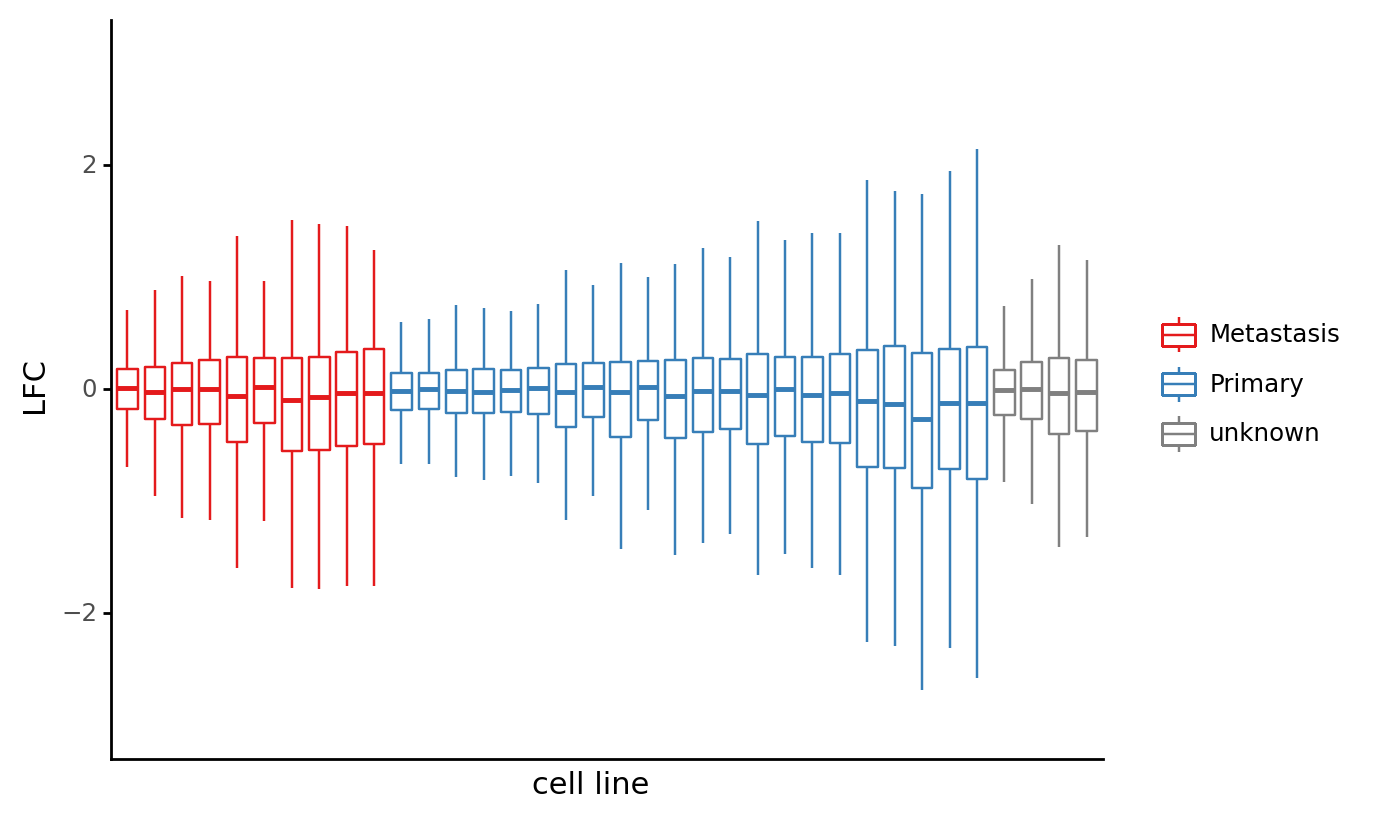

<ggplot: (8751946003005)>

In [3]:
prim_met_pal = (muted_red, muted_blue, "grey")

cell_line_order = (
    data.groupby("depmap_id")["lfc"]
    .agg(np.std)
    .reset_index()
    .merge(
        data[["depmap_id", "primary_or_metastasis"]]
        .drop_duplicates()
        .reset_index(drop=True)
    )
    .sort_values(["primary_or_metastasis", "lfc"])[["depmap_id"]]
    .to_numpy()
    .flatten()
)

plot_data = data.copy().sample(frac=0.01).reset_index(drop=True)
plot_data["depmap_id"] = pd.Categorical(
    plot_data.depmap_id.values.tolist(), categories=cell_line_order, ordered=True
)

(
    ggplot(plot_data, aes(x="depmap_id", y="lfc"))
    + gg.geom_boxplot(aes(color="primary_or_metastasis"), outlier_alpha=0)
    + gg.scale_y_continuous(limits=(-3, 3))
    + gg.scale_color_manual(values=prim_met_pal)
    + gg.theme(
        axis_text_x=gg.element_blank(),
        axis_ticks_major_x=gg.element_blank(),
        legend_title=gg.element_blank(),
    )
    + gg.labs(x="cell line", y="LFC")
)

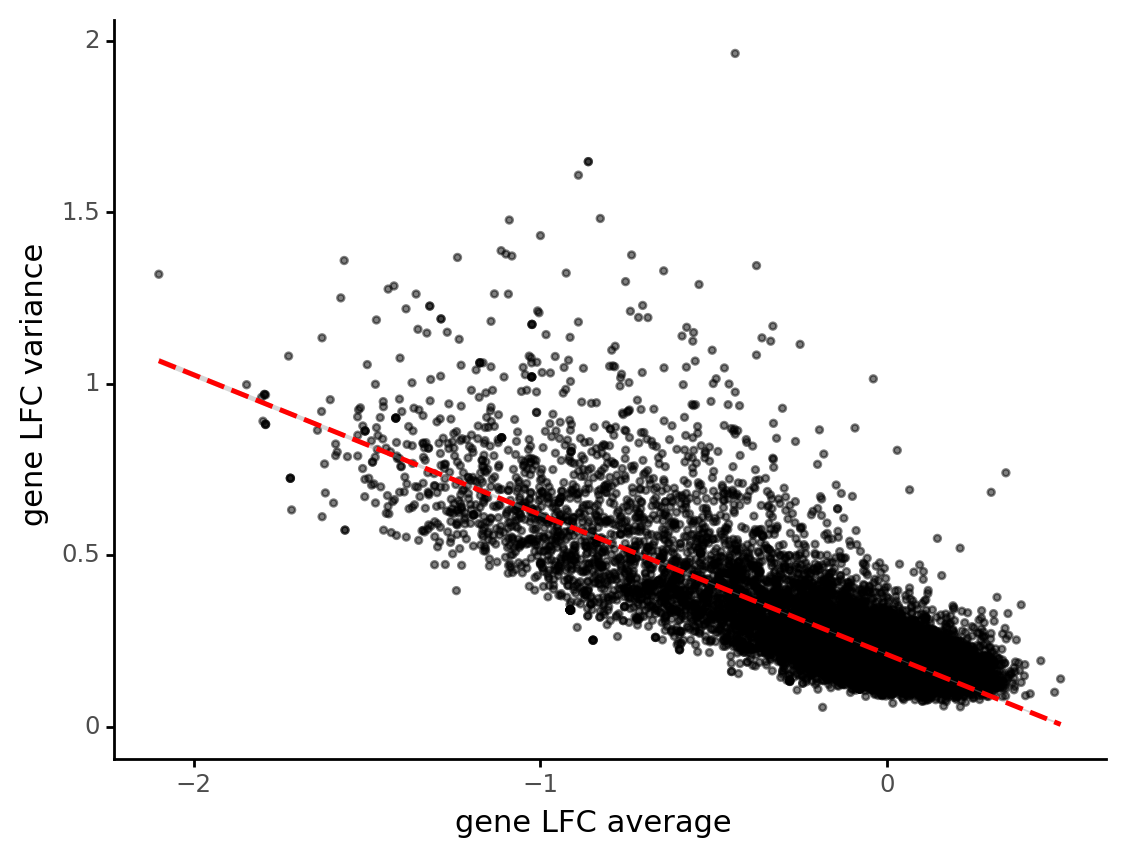

<ggplot: (8751946007787)>

In [4]:
gene_summary = data.groupby("hugo_symbol")["lfc"].agg([np.var, np.mean]).reset_index()
gene_summary = gene_summary.assign(
    label=lambda d: [
        n if np.abs(m) > 1.75 or v > 1.5 else np.nan
        for n, v, m in zip(d["hugo_symbol"], d["var"], d["mean"])
    ]
)

(
    ggplot(gene_summary, aes(x="mean", y="var"))
    + gg.geom_point(alpha=0.5, size=0.9)
    + gg.geom_smooth(color="red", method="lm", se=True, linetype="--")
    + gg.labs(x="gene LFC average", y="gene LFC variance")
)

In [13]:
def plot_line_against_lfc(
    df: pd.DataFrame, x: str, y: str = "lfc", alpha: float = 0.05, size: float = 0.7
) -> gg.ggplot:
    return (
        ggplot(df, aes(x=x, y=y))
        + gg.facet_wrap("depmap_id", ncol=3, scales="free_x")
        + gg.geom_point(size=size, alpha=alpha)
        + gg.geom_smooth(method="lm", se=True, color="red", linetype="--")
        + gg.theme(figure_size=(8, 25), subplots_adjust={"hspace": 0.4, "wspace": 0.1})
        + gg.labs(y="LFC")
    )

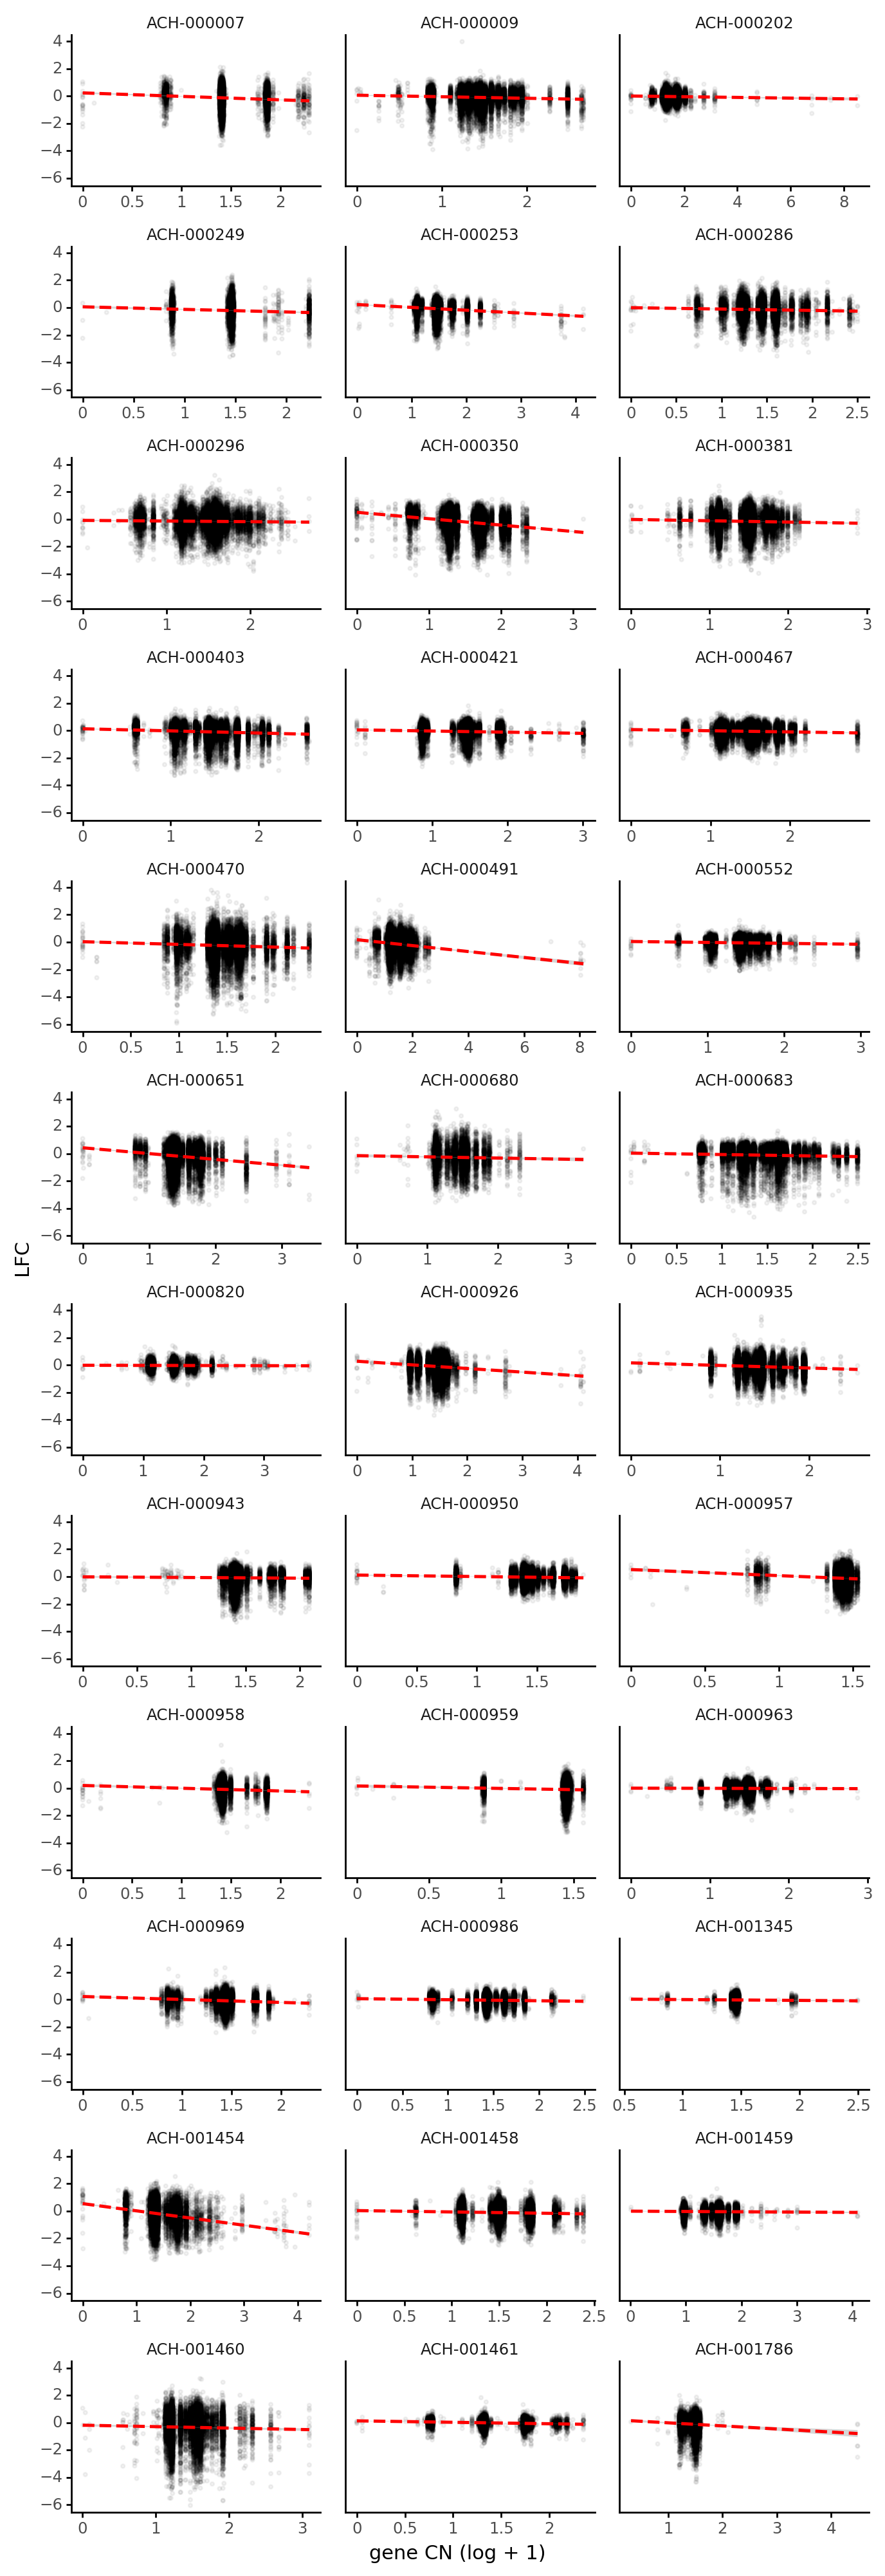

<ggplot: (8751942124535)>

In [16]:
plot_line_against_lfc(data.sample(frac=0.1), x="np.log2(gene_cn + 1)") + gg.labs(
    x="gene CN (log + 1)"
)

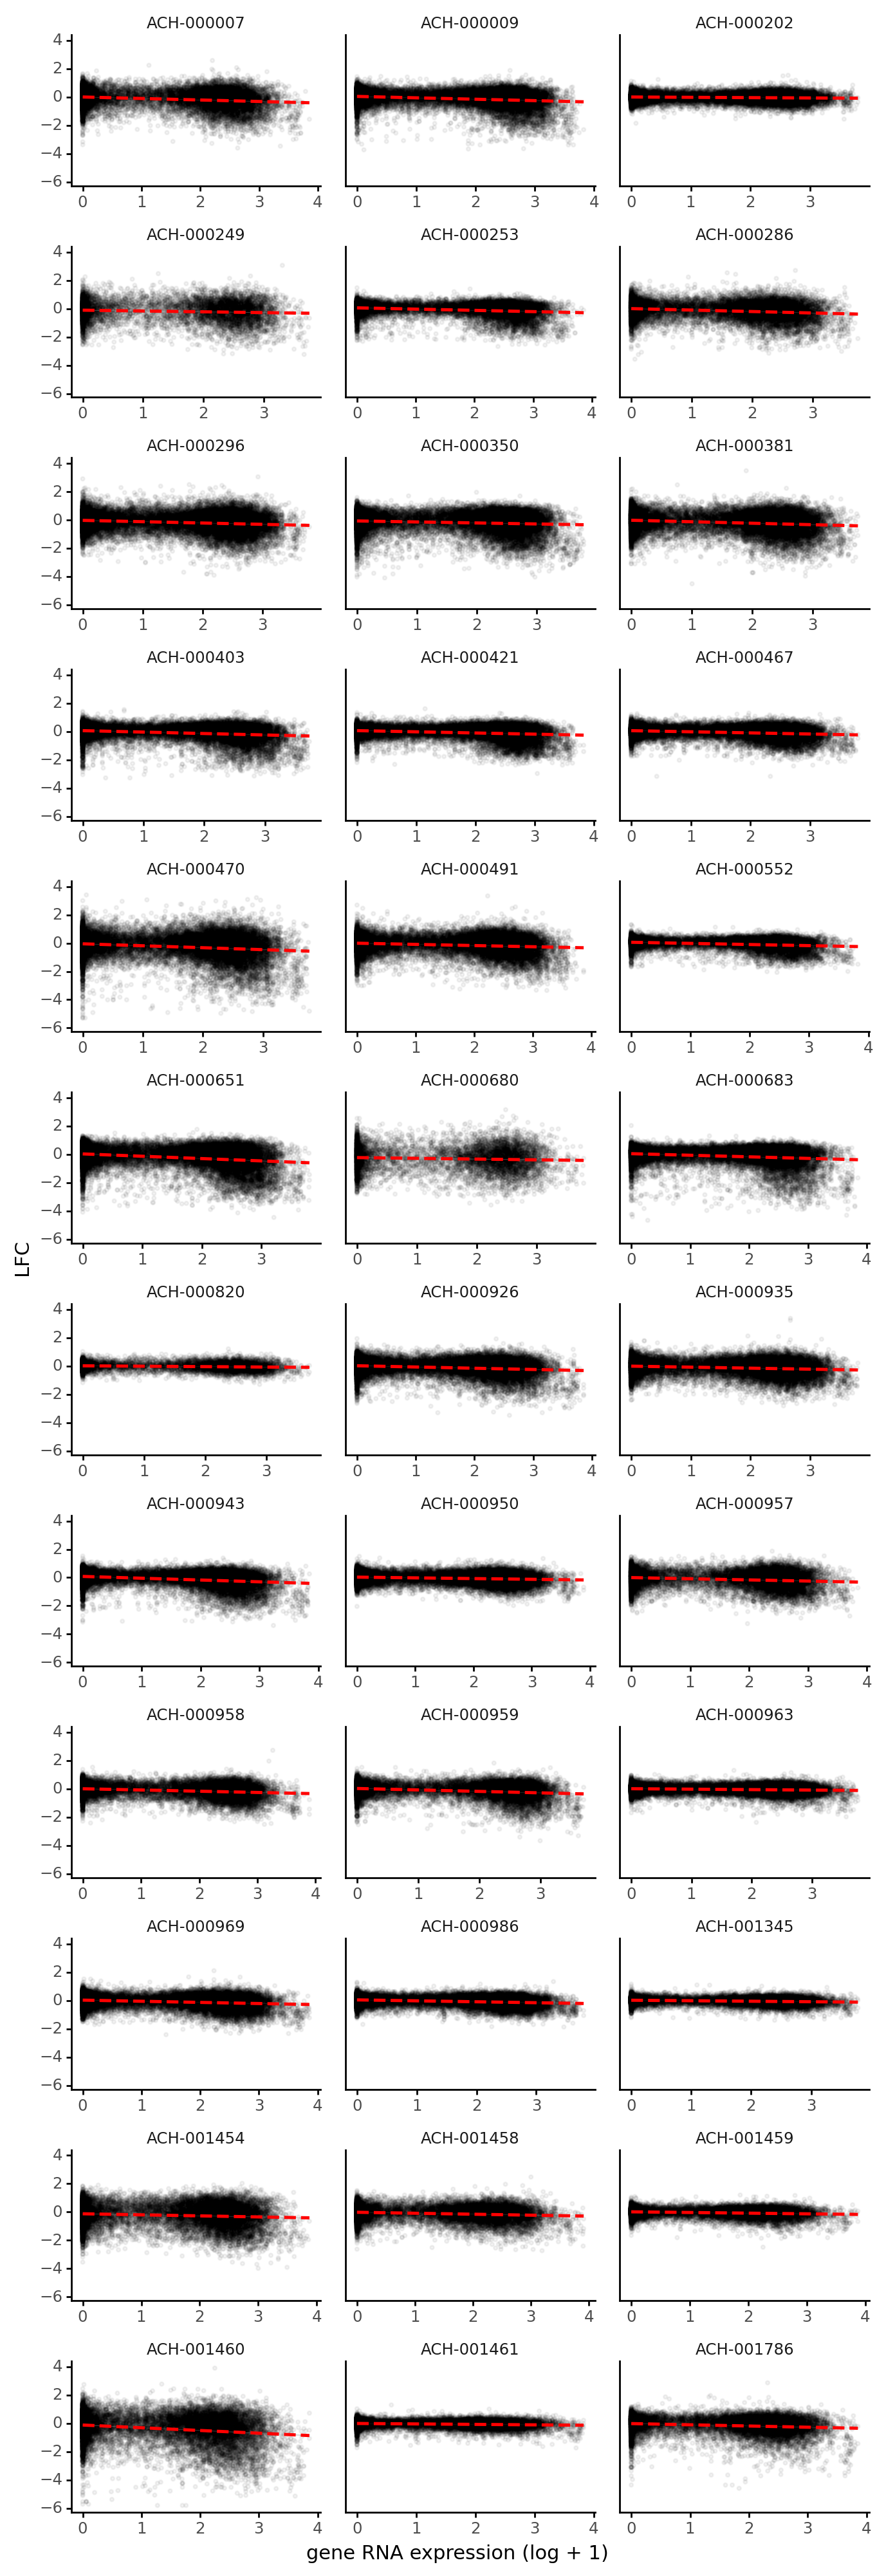

<ggplot: (8751945024464)>

In [17]:
plot_line_against_lfc(data.sample(frac=0.1), x="np.log2(rna_expr + 1)") + gg.labs(
    x="gene RNA expression (log + 1)"
)

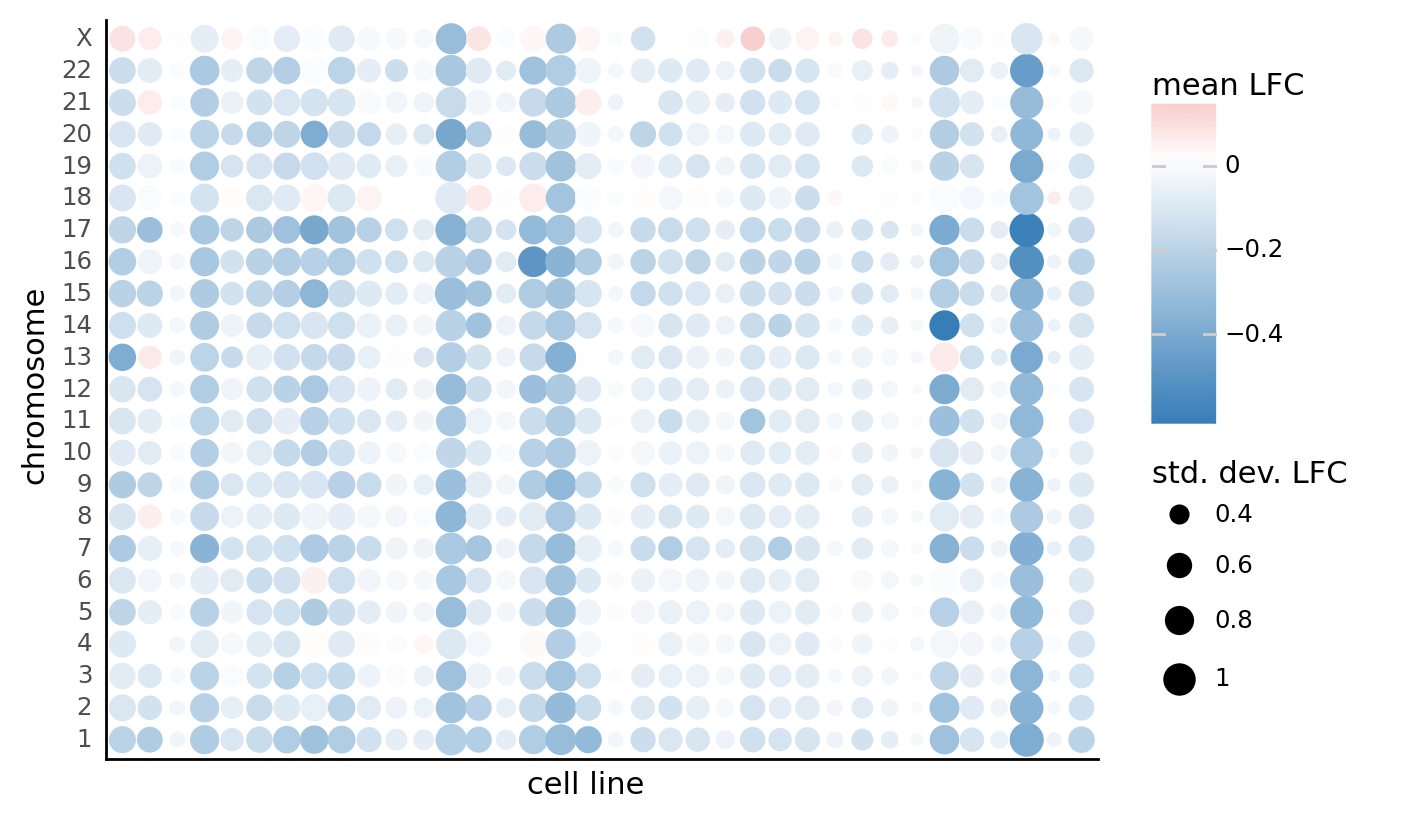

<ggplot: (8751867968588)>

In [43]:
chrom_order = [str(i) for i in range(1, 23)] + ["X"]

cell_chrom_summary = (
    data.groupby(["depmap_id", "chromosome"])["lfc"]
    .agg([np.mean, np.std])
    .reset_index()
)
cell_chrom_summary["chromosome"] = pd.Categorical(
    cell_chrom_summary.chromosome, categories=chrom_order, ordered=True
)

(
    ggplot(cell_chrom_summary, aes(x="depmap_id", y="chromosome"))
    + gg.geom_point(aes(color="mean", size="std"))
    + gg.scale_color_gradient2(low=muted_blue, mid="white", high=muted_red, midpoint=0)
    + gg.theme(
        axis_text_x=gg.element_blank(),
        axis_ticks_major_x=gg.element_blank(),
        axis_ticks_major_y=gg.element_blank(),
    )
    + gg.labs(x="cell line", y="chromosome", color="mean LFC", size="std. dev. LFC")
)

In [45]:
from sklearn.manifold import TSNE

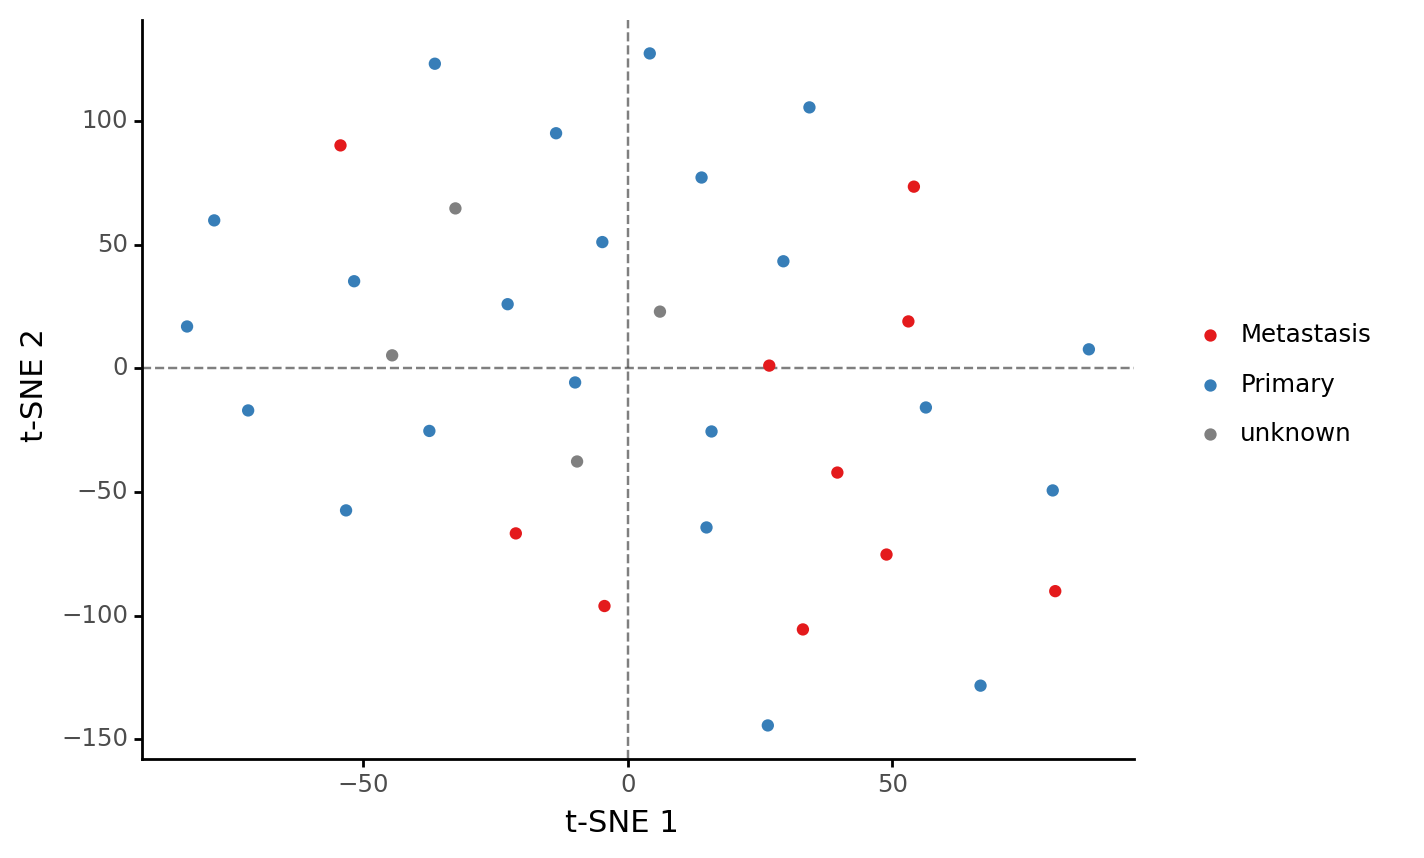

<ggplot: (8751843444125)>

In [112]:
X = (
    data.groupby(["depmap_id", "hugo_symbol"])["lfc"]
    .agg(np.mean)
    .reset_index()
    .pivot("depmap_id", "hugo_symbol", "lfc")
)

gene_var = X.to_numpy().var(axis=0)
top_percentile_var = np.percentile(gene_var, 99)
gene_idx = gene_var >= top_percentile_var

X_embedded = TSNE(n_components=2, init="pca", random_state=RANDOM_SEED).fit_transform(
    X.to_numpy()[:, gene_idx]
)
tsne_res = pd.DataFrame(X_embedded, columns=("x1", "x2")).assign(
    depmap_id=X.index.values.to_numpy()
)
tsne_res = tsne_res.merge(
    data[["depmap_id", "primary_or_metastasis"]]
    .drop_duplicates()
    .reset_index(drop=True)
)

(
    ggplot(tsne_res, aes("x1", "x2"))
    + gg.geom_hline(yintercept=0, alpha=0.5, linetype="--")
    + gg.geom_vline(xintercept=0, alpha=0.5, linetype="--")
    + gg.geom_point(aes(color="primary_or_metastasis"))
    + gg.scale_color_manual(values=prim_met_pal)
    + gg.theme(legend_title=gg.element_blank())
    + gg.labs(x="t-SNE 1", y="t-SNE 2")
)

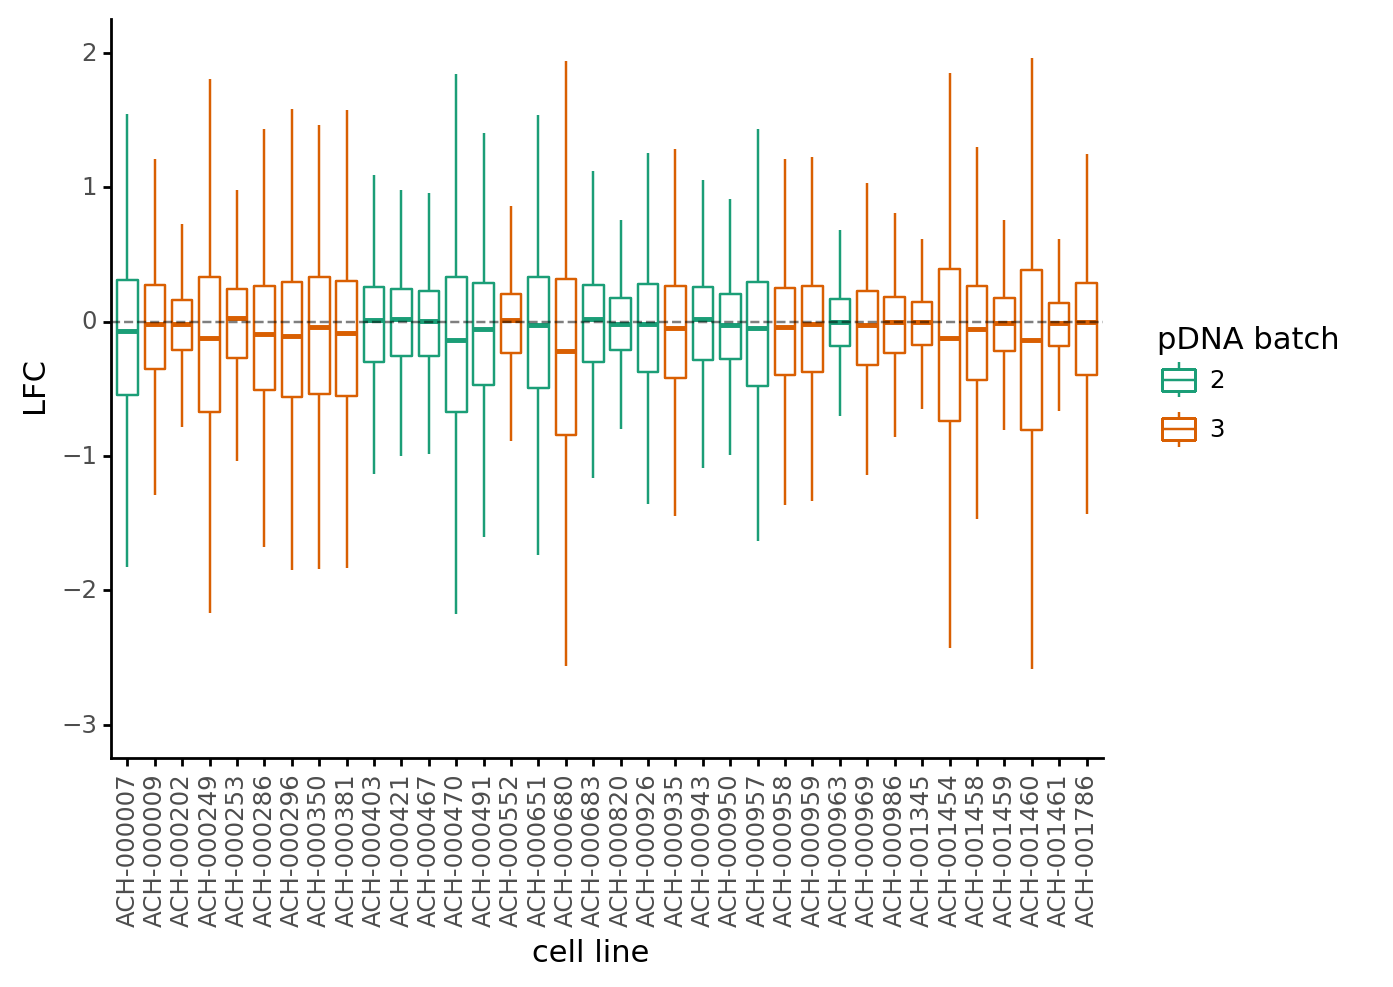

<ggplot: (8751843565526)>

In [121]:
(
    ggplot(data.sample(frac=0.05), aes(x="depmap_id", y="lfc"))
    + gg.geom_boxplot(aes(color="factor(pdna_batch)"), outlier_alpha=0)
    + gg.geom_hline(yintercept=0, alpha=0.5, linetype="--")
    + gg.scale_y_continuous(limits=(-3, 2))
    + gg.scale_color_brewer(type="qual", palette="Dark2")
    + gg.theme(axis_text_x=gg.element_text(angle=90))
    + gg.labs(x="cell line", y="LFC", color="pDNA batch")
)

---

In [6]:
notebook_toc = time()
print(f"execution time: {(notebook_toc - notebook_tic) / 60:.2f} minutes")

execution time: 1.46 minutes


In [7]:
%load_ext watermark
%watermark -d -u -v -iv -b -h -m

Last updated: 2021-02-16

Python implementation: CPython
Python version       : 3.9.1
IPython version      : 7.20.0

Compiler    : GCC 9.3.0
OS          : Linux
Release     : 3.10.0-1062.el7.x86_64
Machine     : x86_64
Processor   : x86_64
CPU cores   : 28
Architecture: 64bit

Hostname: compute-e-16-230.o2.rc.hms.harvard.edu

Git branch: crc

seaborn   : 0.11.1
plotnine  : 0.7.1
numpy     : 1.20.1
matplotlib: 3.3.4
pandas    : 1.2.2
re        : 2.2.1

